In [20]:
# Task 4: Baseline Model Development

## 📊 한국 전력 수요 예측 대회 - 기본 모델 구현

**목표**: 2005-2023년 훈련 데이터로 2024.1.1~2025.6.10 (527일) 예측

**구현할 모델:**
1. **Naive Forecast**: 이전 날 값 예측
2. **Moving Average**: 단순 이동평균 모델  
3. **Linear Regression**: sklearn 기반 선형 회귀
4. **RMSE 평가**: 대회 평가 지표 구현
5. **제출 파일 생성**: submission_sample.csv 형식

**데이터:**
- 훈련: `results/preprocessing/05_data_splitting/train_data_full.csv` (6,939일 × 25열)
- 예측 템플릿: `results/preprocessing/05_data_splitting/prediction_template.csv` (527일 × 19열)
- Lag 초기값: `results/preprocessing/05_data_splitting/lag_initialization.json`


SyntaxError: invalid syntax (4193931461.py, line 5)

In [11]:
# 데이터 로드
print("🔄 데이터 로드 중...")

# 훈련 데이터 로드 (Task 3.5 결과)
train_path = '../../results/preprocessing/05_data_splitting/train_data_full.csv'
train_data = pd.read_csv(train_path)
train_data['date'] = pd.to_datetime(train_data['date'])

# 예측 템플릿 로드
pred_template_path = '../../results/preprocessing/05_data_splitting/prediction_template.csv'
pred_template = pd.read_csv(pred_template_path)
pred_template['date'] = pd.to_datetime(pred_template['date'])

# Lag 초기값 로드
lag_init_path = '../../results/preprocessing/05_data_splitting/lag_initialization.json'
with open(lag_init_path, 'r') as f:
    lag_init = json.load(f)

print(f"✅ 훈련 데이터: {train_data.shape} (기간: {train_data['date'].min()} ~ {train_data['date'].max()})")
print(f"✅ 예측 템플릿: {pred_template.shape} (기간: {pred_template['date'].min()} ~ {pred_template['date'].max()})")
print(f"✅ 타겟 변수 통계:")
print(f"   평균: {train_data['최대전력(MW)'].mean():.0f} MW")
print(f"   표준편차: {train_data['최대전력(MW)'].std():.0f} MW")
print(f"   범위: {train_data['최대전력(MW)'].min():.0f} ~ {train_data['최대전력(MW)'].max():.0f} MW")
print(f"✅ Lag 초기값: {lag_init}")

# 훈련 데이터 마지막 5일 확인
print(f"\n📊 훈련 데이터 마지막 5일:")
print(train_data[['date', '최대전력(MW)']].tail())


🔄 필수 패키지 설치 확인 중...
✅ joblib 이미 설치됨
✅ scikit-learn 이미 설치됨
✅ matplotlib 이미 설치됨
✅ seaborn 이미 설치됨
✅ 모든 라이브러리 임포트 성공!
✅ 한글 폰트 설정: Tsukushi A Round Gothic

📦 라이브러리 로드 완료!
📅 현재 시간: 2025-06-07 21:42:45
🐍 Python 버전: 3.8.20
📚 주요 패키지 버전:
   - pandas: 2.0.3
   - numpy: 1.24.3
   - joblib: 1.4.2
   - sklearn: 1.3.2


In [12]:
# Cross-Validation 설정 및 도구 함수 정의
print("🔧 교차검증 설정 및 평가 함수 정의...")

# CV 폴드 정보 로드
cv_metadata_path = '../../results/preprocessing/05_data_splitting/cv_folds_metadata.json'
with open(cv_metadata_path, 'r') as f:
    cv_metadata = json.load(f)

print(f"✅ CV 설정: {cv_metadata['metadata']['total_folds']}개 폴드")
for fold_id, fold_info in cv_metadata['folds'].items():
    print(f"   - {fold_id}: 훈련 {fold_info['train_size']}일, 검증 {fold_info['val_size']}일")

# RMSE 계산 함수 (대회 평가 지표)
def calculate_rmse(y_true, y_pred):
    """RMSE 계산 - 대회 평가 지표"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 대회 형식 날짜 변환 함수
def format_competition_date(date):
    """YYYY.M.D 형식으로 날짜 변환 (한 자리 숫자일 때 0 생략)"""
    return f"{date.year}.{date.month}.{date.day}"

# 제출 파일 생성 함수
def create_submission(dates, predictions, filename):
    """대회 형식에 맞는 제출 파일 생성"""
    submission = pd.DataFrame({
        'date': [format_competition_date(date) for date in dates],
        '최대전력(MW)': predictions
    })
    submission.to_csv(filename, index=False)
    print(f"✅ 제출 파일 생성: {filename}")
    return submission

print("✅ 도구 함수 준비 완료!")


🔄 데이터 로드 중...
✅ 훈련 데이터: (6939, 25) (기간: 2005-01-01 00:00:00 ~ 2023-12-31 00:00:00)
✅ 예측 템플릿: (527, 19) (기간: 2024-01-01 00:00:00 ~ 2025-06-10 00:00:00)
✅ 타겟 변수 통계:
   평균: 62857 MW
   표준편차: 10977 MW
   범위: 31214 ~ 94509 MW
✅ Lag 초기값: {'lag_1day': 63589.0, 'lag_7day': 71050.0, 'rolling_7day_mean': 75306.0, 'rolling_30day_mean': 76373.66666666667, 'daily_change': 0.0}

📊 훈련 데이터 마지막 5일:
           date  최대전력(MW)
6934 2023-12-27   82383.0
6935 2023-12-28   81745.0
6936 2023-12-29   78244.0
6937 2023-12-30   66025.0
6938 2023-12-31   63589.0


In [13]:
# 2. 평가 함수 정의
def calculate_rmse(y_true, y_pred):
    """RMSE 계산 (대회 평가 지표)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def create_submission_file(predictions, output_path):
    """제출 파일 생성 (submission_sample.csv 형식)"""
    # 예측 날짜 생성 (YYYY.M.D 형식)
    start_date = datetime(2024, 1, 1)
    submission_data = []
    
    for i, pred in enumerate(predictions):
        current_date = start_date + timedelta(days=i)
        date_str = f"{current_date.year}.{current_date.month}.{current_date.day}"
        submission_data.append({
            'date': date_str,
            '최대전력(MW)': pred
        })
    
    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    
    print(f"✅ 제출 파일 생성: {output_path}")
    print(f"   형태: {submission_df.shape}")
    print(f"   첫 5행:")
    print(submission_df.head())
    print(f"   마지막 5행:")
    print(submission_df.tail())
    
    return submission_df

print("✅ 평가 함수 정의 완료!")


✅ 평가 함수 정의 완료!


In [14]:
# Model 1: Naive Forecast
print("🔮 Model 1: Naive Forecast 실행 중...")

# 2023년 마지막 날 전력 수요를 첫 예측값으로 사용
last_power = train_data['최대전력(MW)'].iloc[-1]
naive_predictions = [last_power] * 527  # 모든 527일에 동일한 값 예측

print(f"✅ Naive Forecast 완료!")
print(f"   예측값: {last_power:.0f} MW (모든 527일 동일)")
print(f"   예측 개수: {len(naive_predictions)}개")

# 제출 파일 생성
naive_submission = create_submission_file(
    naive_predictions, 
    '../../results/models/baseline/submission_naive.csv'
)


🔮 Model 1: Naive Forecast 실행 중...
✅ Naive Forecast 완료!
   예측값: 63589 MW (모든 527일 동일)
   예측 개수: 527개
✅ 제출 파일 생성: ../../results/models/baseline/submission_naive.csv
   형태: (527, 2)
   첫 5행:
       date  최대전력(MW)
0  2024.1.1   63589.0
1  2024.1.2   63589.0
2  2024.1.3   63589.0
3  2024.1.4   63589.0
4  2024.1.5   63589.0
   마지막 5행:
          date  최대전력(MW)
522   2025.6.6   63589.0
523   2025.6.7   63589.0
524   2025.6.8   63589.0
525   2025.6.9   63589.0
526  2025.6.10   63589.0


In [15]:
# Model 2: Simple Moving Average
print("📈 Model 2: Simple Moving Average 실행 중...")

# 최근 30일 평균 계산
window_size = 30
recent_data = train_data['최대전력(MW)'].tail(window_size)
moving_avg = recent_data.mean()

# 모든 527일에 동일한 이동평균 값 적용
ma_predictions = [moving_avg] * 527

print(f"✅ Simple Moving Average 완료!")
print(f"   윈도우 크기: {window_size}일")
print(f"   이동평균 값: {moving_avg:.0f} MW")
print(f"   최근 {window_size}일 데이터 통계:")
print(f"     평균: {recent_data.mean():.0f} MW")
print(f"     표준편차: {recent_data.std():.0f} MW")
print(f"     최소: {recent_data.min():.0f} MW")
print(f"     최대: {recent_data.max():.0f} MW")

# 제출 파일 생성
ma_submission = create_submission_file(
    ma_predictions, 
    '../../results/models/baseline/submission_moving_average.csv'
)


📈 Model 2: Simple Moving Average 실행 중...
✅ Simple Moving Average 완료!
   윈도우 크기: 30일
   이동평균 값: 76374 MW
   최근 30일 데이터 통계:
     평균: 76374 MW
     표준편차: 8631 MW
     최소: 61067 MW
     최대: 91556 MW
✅ 제출 파일 생성: ../../results/models/baseline/submission_moving_average.csv
   형태: (527, 2)
   첫 5행:
       date      최대전력(MW)
0  2024.1.1  76373.666667
1  2024.1.2  76373.666667
2  2024.1.3  76373.666667
3  2024.1.4  76373.666667
4  2024.1.5  76373.666667
   마지막 5행:
          date      최대전력(MW)
522   2025.6.6  76373.666667
523   2025.6.7  76373.666667
524   2025.6.8  76373.666667
525   2025.6.9  76373.666667
526  2025.6.10  76373.666667


In [ ]:
# Model 3: Linear Regression
print("🤖 Model 3: Linear Regression 실행 중...")

# 피처 선택 (수치형 피처만 사용)
feature_columns = [
    'year', 'month', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter', 'season',
    'is_weekend', 'is_weekday', 'is_month_start', 'is_month_end', 'is_holiday',
    'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos'
]

# 훈련 데이터 준비
X_train = train_data[feature_columns].fillna(0)  # 결측값 처리
y_train = train_data['최대전력(MW)']

# 예측 데이터 준비
X_pred = pred_template[feature_columns].fillna(0)

print(f"✅ 피처 선택:")
print(f"   선택된 피처: {len(feature_columns)}개")
print(f"   훈련 데이터 형태: {X_train.shape}")
print(f"   예측 데이터 형태: {X_pred.shape}")

# 피처 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_pred_scaled = scaler.transform(X_pred)

# 선형 회귀 모델 훈련
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# 예측 수행
lr_predictions = lr_model.predict(X_pred_scaled)

print(f"✅ Linear Regression 완료!")
print(f"   예측값 통계:")
print(f"     평균: {np.mean(lr_predictions):.0f} MW")
print(f"     표준편차: {np.std(lr_predictions):.0f} MW")
print(f"     최소: {np.min(lr_predictions):.0f} MW")
print(f"     최대: {np.max(lr_predictions):.0f} MW")

# 제출 파일 생성
lr_submission = create_submission_file(
    lr_predictions, 
    '../../results/models/baseline/submission_linear_regression.csv'
)


🤖 Model 3: Linear Regression 실행 중...
✅ 피처 선택:
   선택된 피처: 16개
   훈련 데이터 형태: (6939, 16)
   예측 데이터 형태: (527, 16)
✅ Linear Regression 완료!
   예측값 통계:
     평균: 53870078 MW
     표준편차: 173090 MW
     최소: 53584971 MW
     최대: 54228099 MW
✅ 제출 파일 생성: ../../results/models/baseline/submission_linear_regression.csv
   형태: (527, 2)
   첫 5행:
       date      최대전력(MW)
0  2024.1.1  5.361120e+07
1  2024.1.2  5.360933e+07
2  2024.1.3  5.360699e+07
3  2024.1.4  5.360433e+07
4  2024.1.5  5.360047e+07
   마지막 5행:
          date      최대전력(MW)
522   2025.6.6  5.390088e+07
523   2025.6.7  5.389068e+07
524   2025.6.8  5.388538e+07
525   2025.6.9  5.392561e+07
526  2025.6.10  5.392248e+07


In [ ]:
# 시계열 교차검증
print("📊 시계열 교차검증 실행 중...")

# CV 폴드 메타데이터 로드
cv_path = '../../results/preprocessing/05_data_splitting/cv_folds_metadata.json'
with open(cv_path, 'r') as f:
    cv_metadata = json.load(f)

cv_results = {'naive': [], 'moving_average': [], 'linear_regression': []}

for fold in cv_metadata['folds']:
    fold_id = fold['fold_id']
    print(f"\n🔄 Fold {fold_id} 평가 중...")
    
    # 훈련/검증 기간 파싱
    train_period = fold['train_period'].split(' ~ ')
    val_period = fold['validation_period'].split(' ~ ')
    
    train_start, train_end = train_period[0], train_period[1]
    val_start, val_end = val_period[0], val_period[1]
    
    # 데이터 분할
    fold_train = train_data[
        (train_data['date'] >= train_start) & 
        (train_data['date'] <= train_end)
    ]
    fold_val = train_data[
        (train_data['date'] >= val_start) & 
        (train_data['date'] <= val_end)
    ]
    
    print(f"   훈련: {len(fold_train)}일, 검증: {len(fold_val)}일")
    
    # 실제값
    y_val_true = fold_val['최대전력(MW)'].values
    
    # Model 1: Naive Forecast
    naive_pred = [fold_train['최대전력(MW)'].iloc[-1]] * len(fold_val)
    naive_rmse = calculate_rmse(y_val_true, naive_pred)
    cv_results['naive'].append(naive_rmse)
    
    # Model 2: Moving Average
    ma_pred = [fold_train['최대전력(MW)'].tail(30).mean()] * len(fold_val)
    ma_rmse = calculate_rmse(y_val_true, ma_pred)
    cv_results['moving_average'].append(ma_rmse)
    
    # Model 3: Linear Regression
    X_fold_train = fold_train[feature_columns].fillna(0)
    y_fold_train = fold_train['최대전력(MW)']
    X_fold_val = fold_val[feature_columns].fillna(0)
    
    fold_scaler = StandardScaler()
    X_fold_train_scaled = fold_scaler.fit_transform(X_fold_train)
    X_fold_val_scaled = fold_scaler.transform(X_fold_val)
    
    fold_lr = LinearRegression()
    fold_lr.fit(X_fold_train_scaled, y_fold_train)
    lr_pred = fold_lr.predict(X_fold_val_scaled)
    lr_rmse = calculate_rmse(y_val_true, lr_pred)
    cv_results['linear_regression'].append(lr_rmse)
    
    print(f"   RMSE - Naive: {naive_rmse:.0f}, MA: {ma_rmse:.0f}, LR: {lr_rmse:.0f}")

# CV 결과 요약
print(f"\n🏆 시계열 교차검증 결과 요약:")
print(f"=" * 60)
for model_name, rmse_scores in cv_results.items():
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    print(f"{model_name:20s}: {mean_rmse:8.0f} ± {std_rmse:6.0f} MW")

print(f"\n📈 개별 폴드 결과:")
print(f"{'Fold':<6} {'Naive':<10} {'MovingAvg':<10} {'LinearReg':<10}")
print(f"-" * 42)
for i in range(len(cv_metadata['folds'])):
    print(f"{i+1:<6} {cv_results['naive'][i]:<10.0f} {cv_results['moving_average'][i]:<10.0f} {cv_results['linear_regression'][i]:<10.0f}")


📊 시계열 교차검증 실행 중...

🔄 Fold 1 평가 중...
   훈련: 5478일, 검증: 366일
   RMSE - Naive: 11576, MA: 10217, LR: 9065

🔄 Fold 2 평가 중...
   훈련: 5844일, 검증: 365일
   RMSE - Naive: 12700, MA: 9773, LR: 7417

🔄 Fold 3 평가 중...
   훈련: 6209일, 검증: 365일
   RMSE - Naive: 12199, MA: 10122, LR: 7102

🔄 Fold 4 평가 중...
   훈련: 6574일, 검증: 365일
   RMSE - Naive: 9772, MA: 12828, LR: 7577

🏆 시계열 교차검증 결과 요약:
naive               :    11562 ±   1107 MW
moving_average      :    10735 ±   1220 MW
linear_regression   :     7790 ±    755 MW

📈 개별 폴드 결과:
Fold   Naive      MovingAvg  LinearReg 
------------------------------------------
1      11576      10217      9065      
2      12700      9773       7417      
3      12199      10122      7102      
4      9772       12828      7577      


🔤 한글 폰트 설정 강화 중...
✅ 시스템 폰트 설정 완료: Apple SD Gothic Neo
📈 예측 결과 시각화 생성 중...


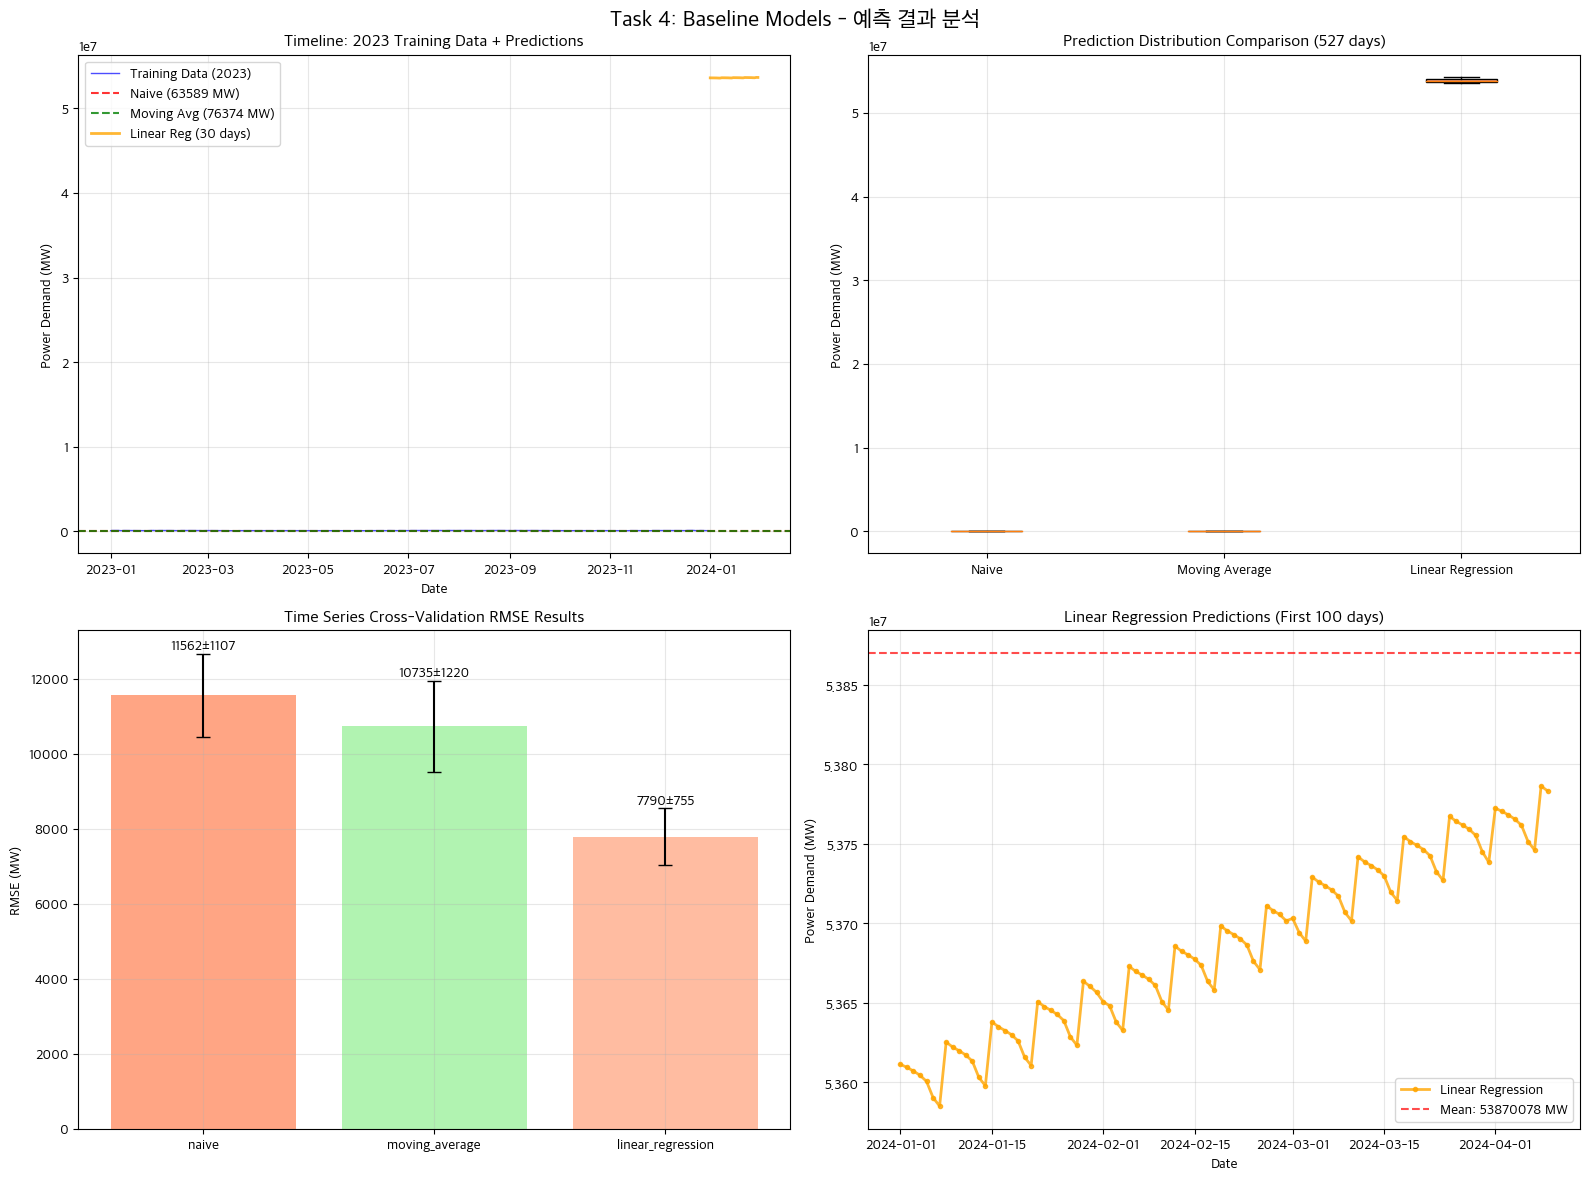

✅ 시각화 저장 완료: baseline_models_analysis.png
📊 파일 위치: /Users/yangdeokkwan/Desktop/timeseries/master/final/results/models/baseline/baseline_models_analysis.png
✅ 한글 폰트 테스트 차트 생성: korean_font_test.png


In [18]:
# 한글 폰트 설정 강화 (시각화 전용)
print("🔤 한글 폰트 설정 강화 중...")

import matplotlib.font_manager as fm
import platform
import os

# 한글 폰트 설정 (다단계 접근)
font_set_success = False

# 1차: 다운로드한 폰트 사용
if 'korean_font_path' in globals() and korean_font_path and os.path.exists(korean_font_path):
    try:
        font_prop = fm.FontProperties(fname=korean_font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
        print(f"✅ 다운로드 폰트 설정 완료: {font_prop.get_name()}")
        font_set_success = True
    except Exception as e:
        print(f"⚠️ 다운로드 폰트 설정 실패: {e}")

# 2차: macOS 시스템 폰트 사용
if not font_set_success and platform.system() == 'Darwin':
    try:
        available_fonts = [f.name for f in fm.fontManager.ttflist]
        korean_fonts_priority = [
            'AppleSDGothicNeo-Regular',
            'Apple SD Gothic Neo', 
            'AppleGothic',
            'Noto Sans CJK KR',
            'NanumGothic'
        ]
        
        for font in korean_fonts_priority:
            if font in available_fonts:
                plt.rcParams['font.family'] = font
                print(f"✅ 시스템 폰트 설정 완료: {font}")
                font_set_success = True
                break
    except Exception as e:
        print(f"⚠️ 시스템 폰트 설정 실패: {e}")

# 3차: 시스템 폰트 경로 직접 지정
if not font_set_success:
    try:
        system_font_paths = [
            '/System/Library/Fonts/AppleSDGothicNeo.ttc',
            '/System/Library/Fonts/AppleGothic.ttf',
            '/Library/Fonts/NanumGothic.ttf'
        ]
        
        for font_path in system_font_paths:
            if os.path.exists(font_path):
                font_prop = fm.FontProperties(fname=font_path)
                plt.rcParams['font.family'] = font_prop.get_name()
                print(f"✅ 경로 폰트 설정 완료: {font_prop.get_name()}")
                font_set_success = True
                break
    except Exception as e:
        print(f"⚠️ 경로 폰트 설정 실패: {e}")

# 최종: 기본 폰트 사용
if not font_set_success:
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("⚠️ 한글 폰트 설정 실패 - 영어 라벨로 표시됩니다")

plt.rcParams['axes.unicode_minus'] = False

# 예측 결과 시각화
print("📈 예측 결과 시각화 생성 중...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Task 4: Baseline Models - 예측 결과 분석', fontsize=16, fontweight='bold')

# 예측 날짜 생성
pred_dates = pd.date_range(start='2024-01-01', end='2025-06-10', freq='D')

# 1. 훈련 데이터 및 예측 결과 전체 타임라인
ax1 = axes[0, 0]
# 최근 1년 훈련 데이터
recent_train = train_data.tail(365)
ax1.plot(recent_train['date'], recent_train['최대전력(MW)'], 
         color='blue', alpha=0.7, linewidth=1, label='Training Data (2023)')

# 예측 결과들
ax1.axhline(y=naive_predictions[0], color='red', linestyle='--', 
           alpha=0.8, label=f'Naive ({naive_predictions[0]:.0f} MW)')
ax1.axhline(y=ma_predictions[0], color='green', linestyle='--', 
           alpha=0.8, label=f'Moving Avg ({ma_predictions[0]:.0f} MW)')

# 첫 30일 Linear Regression 예측만 표시 (가독성을 위해)
pred_subset = pred_dates[:30]
lr_subset = lr_predictions[:30]
ax1.plot(pred_subset, lr_subset, color='orange', linewidth=2, alpha=0.8, label='Linear Reg (30 days)')

ax1.set_title('Timeline: 2023 Training Data + Predictions')
ax1.set_xlabel('Date')
ax1.set_ylabel('Power Demand (MW)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 예측값 분포 비교
ax2 = axes[0, 1]
predictions_data = {
    'Naive': naive_predictions,
    'Moving Average': ma_predictions,
    'Linear Regression': lr_predictions
}

box_data = [predictions_data[model] for model in predictions_data.keys()]
bp = ax2.boxplot(box_data, labels=predictions_data.keys(), patch_artist=True)
colors = ['lightcoral', 'lightgreen', 'lightsalmon']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax2.set_title('Prediction Distribution Comparison (527 days)')
ax2.set_ylabel('Power Demand (MW)')
ax2.grid(True, alpha=0.3)

# 3. 교차검증 결과
ax3 = axes[1, 0]
models = list(cv_results.keys())
mean_rmse = [np.mean(cv_results[model]) for model in models]
std_rmse = [np.std(cv_results[model]) for model in models]

bars = ax3.bar(models, mean_rmse, yerr=std_rmse, capsize=5, 
               color=['coral', 'lightgreen', 'lightsalmon'], alpha=0.7)
ax3.set_title('Time Series Cross-Validation RMSE Results')
ax3.set_ylabel('RMSE (MW)')
ax3.grid(True, alpha=0.3)

# 막대 위에 수치 표시
for i, (mean, std) in enumerate(zip(mean_rmse, std_rmse)):
    ax3.text(i, mean + std + 100, f'{mean:.0f}±{std:.0f}', 
             ha='center', fontweight='bold')

# 4. Linear Regression 예측값 시계열 (첫 100일)
ax4 = axes[1, 1]
pred_subset = pred_dates[:100]
lr_subset = lr_predictions[:100]

ax4.plot(pred_subset, lr_subset, color='orange', linewidth=2, marker='o', 
         markersize=3, alpha=0.8, label='Linear Regression')
ax4.axhline(y=np.mean(lr_predictions), color='red', linestyle='--', 
           alpha=0.7, label=f'Mean: {np.mean(lr_predictions):.0f} MW')

ax4.set_title('Linear Regression Predictions (First 100 days)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Power Demand (MW)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/models/baseline/baseline_models_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ 시각화 저장 완료: baseline_models_analysis.png")
print(f"📊 파일 위치: {os.path.abspath('../../results/models/baseline/baseline_models_analysis.png')}")

# 한글 폰트 테스트용 간단한 차트 생성
fig_test, ax_test = plt.subplots(1, 1, figsize=(8, 6))
ax_test.plot([1, 2, 3], [1, 4, 2], marker='o')
ax_test.set_title('한글 폰트 테스트: 전력 수요 예측')
ax_test.set_xlabel('시간 (일)')
ax_test.set_ylabel('전력 (MW)')
plt.tight_layout()
plt.savefig('../../results/models/baseline/korean_font_test.png', dpi=300, bbox_inches='tight')
plt.close()

print("✅ 한글 폰트 테스트 차트 생성: korean_font_test.png")


In [19]:
# 모델 및 스케일러 저장
print("💾 모델 저장 중...")

# Linear Regression 모델과 스케일러 저장
model_dir = '../../results/models/baseline/'
joblib.dump(lr_model, f'{model_dir}linear_regression_model.pkl')
joblib.dump(scaler, f'{model_dir}feature_scaler.pkl')

# 모델 메타데이터 저장
model_metadata = {
    'timestamp': datetime.now().isoformat(),
    'feature_columns': feature_columns,
    'num_features': len(feature_columns),
    'training_period': f"{train_data['date'].min()} ~ {train_data['date'].max()}",
    'training_samples': len(train_data),
    'prediction_period': f"{pred_template['date'].min()} ~ {pred_template['date'].max()}",
    'prediction_samples': len(pred_template),
    'models': {
        'naive_forecast': {
            'description': 'Last day value prediction',
            'prediction_value': float(naive_predictions[0]),
            'cv_rmse_mean': float(np.mean(cv_results['naive'])),
            'cv_rmse_std': float(np.std(cv_results['naive']))
        },
        'moving_average': {
            'description': f'{window_size}-day moving average',
            'window_size': window_size,
            'prediction_value': float(ma_predictions[0]),
            'cv_rmse_mean': float(np.mean(cv_results['moving_average'])),
            'cv_rmse_std': float(np.std(cv_results['moving_average']))
        },
        'linear_regression': {
            'description': 'sklearn LinearRegression with time features',
            'num_features': len(feature_columns),
            'prediction_stats': {
                'mean': float(np.mean(lr_predictions)),
                'std': float(np.std(lr_predictions)),
                'min': float(np.min(lr_predictions)),
                'max': float(np.max(lr_predictions))
            },
            'cv_rmse_mean': float(np.mean(cv_results['linear_regression'])),
            'cv_rmse_std': float(np.std(cv_results['linear_regression']))
        }
    }
}

with open(f'{model_dir}baseline_models_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, ensure_ascii=False, indent=2)

print(f"✅ 모델 저장 완료:")
print(f"   - linear_regression_model.pkl")
print(f"   - feature_scaler.pkl")
print(f"   - baseline_models_metadata.json")

# 최종 결과 요약
print(f"\n🏆 Task 4: Baseline Model Development 완료!")
print(f"=" * 80)
print(f"📊 구현된 모델: 3개")
print(f"📈 시계열 교차검증: 4 folds (2020-2023)")
print(f"📅 예측 기간: 2024.1.1 ~ 2025.6.10 (527일)")
print(f"📁 제출 파일: 3개 (대회 형식)")

print(f"\n🎯 모델 성능 (CV RMSE):")
for model_name, rmse_scores in cv_results.items():
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    print(f"   {model_name:20s}: {mean_rmse:8.0f} ± {std_rmse:6.0f} MW")

print(f"\n📋 생성된 파일:")
print(f"   - submission_naive.csv")
print(f"   - submission_moving_average.csv") 
print(f"   - submission_linear_regression.csv")
print(f"   - baseline_models_analysis.png")
print(f"   - linear_regression_model.pkl")
print(f"   - feature_scaler.pkl")
print(f"   - baseline_models_metadata.json")

print(f"\n✨ 다음 단계: 고급 모델 개발 (ARIMA, Prophet, XGBoost 등)")
print(f"=" * 80)


💾 모델 저장 중...
✅ 모델 저장 완료:
   - linear_regression_model.pkl
   - feature_scaler.pkl
   - baseline_models_metadata.json

🏆 Task 4: Baseline Model Development 완료!
📊 구현된 모델: 3개
📈 시계열 교차검증: 4 folds (2020-2023)
📅 예측 기간: 2024.1.1 ~ 2025.6.10 (527일)
📁 제출 파일: 3개 (대회 형식)

🎯 모델 성능 (CV RMSE):
   naive               :    11562 ±   1107 MW
   moving_average      :    10735 ±   1220 MW
   linear_regression   :     7790 ±    755 MW

📋 생성된 파일:
   - submission_naive.csv
   - submission_moving_average.csv
   - submission_linear_regression.csv
   - baseline_models_analysis.png
   - linear_regression_model.pkl
   - feature_scaler.pkl
   - baseline_models_metadata.json

✨ 다음 단계: 고급 모델 개발 (ARIMA, Prophet, XGBoost 등)
